In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from algorithms import *
from utils import *
from load_data import *

In [2]:
group_ys = pickle.load(open('data_processed/hmda/hmda_group_ys.pkl', 'rb'))
groups = pickle.load(open('data_processed/hmda/hmda_groups.pkl', 'rb'))
base_rates = pickle.load(open('data_processed/hmda/hmda_base_rates.pkl', 'rb'))

### computing rhos

In [3]:
alldata = pd.read_csv('data/hmda/cleaned_hmda_nolei.csv')
all_reports = pd.read_csv('data_processed/hmda/hmda_denials.csv')

/tmp/ipykernel_742499/2747184557.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  alldata = pd.read_csv('data/hmda/cleaned_hmda_nolei.csv')
/tmp/ipykernel_742499/2747184557.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_reports = pd.read_csv('data_processed/hmda/hmda_denials.csv')


In [4]:
def compute_rhos(reports, alldata, group_ys, base_rates, pr_y=0.02058):
    r = len(all_reports)/len(alldata)
    pr_rmidg = np.array([get_group_report_rate(reports, group) for group in groups])*r/base_rates
    rho_g = pr_rmidg/group_ys
    print("average rho:", r/pr_y)
    print("max rho:", max(rho_g))
    print("max b:", max(rho_g*pr_y/r))
    print("90 percentile b:", np.percentile(rho_g*pr_y/r, 90))
    print("95 percentile b:", np.percentile(rho_g*pr_y/r, 95))

    print(np.mean(1.2 > rho_g*pr_y/r))
    print(np.mean(1.4 > rho_g*pr_y/r))
    print(np.mean(1.6 > rho_g*pr_y/r))
    print(np.mean(1.8 > rho_g*pr_y/r))

    plt.hist(rho_g*pr_y/r, bins=20)
    
    

average rho: 3.2164290463495924
max rho: 7.403225806451613
max b: 2.3016910056989204
90 percentile b: 1.456171610255781
95 percentile b: 1.5068531487634669
0.6782608695652174
0.8695652173913043
0.9652173913043478
0.9652173913043478


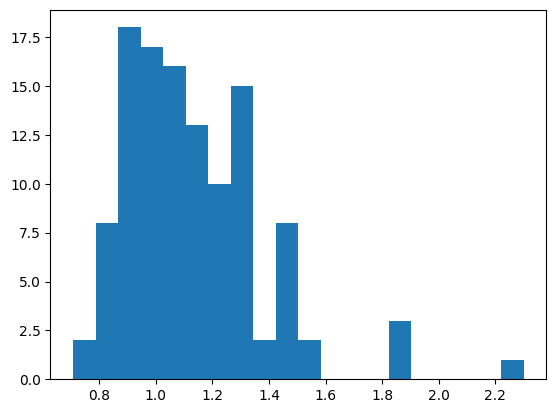

In [5]:
compute_rhos(all_reports, alldata, group_ys, base_rates)

/home/eecs/jessicadai/incidents/load_data.py:83: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_denials = pd.read_csv('data_processed/hmda/hmda_denials.csv')


average rho: 3.2164290463495924
max rho: 4.624848191266377
max b: 1.4378828584809713
90 percentile b: 1.1859051423267182
95 percentile b: 1.2132437357054981


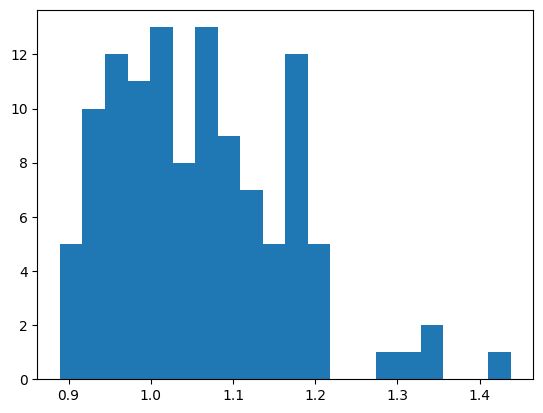

In [86]:
corr_reports, _,_ = get_data('hmda_corr')
compute_rhos(corr_reports, alldata, group_ys, base_rates)

/home/eecs/jessicadai/incidents/load_data.py:83: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_denials = pd.read_csv('data_processed/hmda/hmda_denials.csv')


average rho: 3.2164290463495924
max rho: 8.727135047413944
max b: 2.7132994142428206
90 percentile b: 1.7221481259637923
95 percentile b: 1.7868653443269313


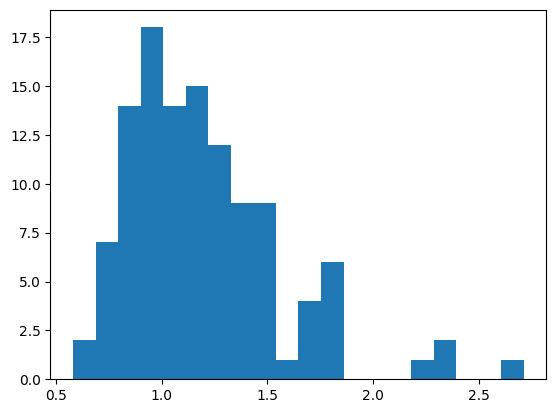

In [87]:
anticorr_reports, _,_ = get_data('hmda_anticorr')
compute_rhos(anticorr_reports, alldata, group_ys, base_rates)

In [9]:
corr_reports

,race,sex,age,dti
55361,white,f,45-54,healthy
56373,white,m,35-44,healthy
30378,white,f,55-64,manageable
12653,white,m,45-54,unmanageable
31628,white,f,25-34,manageable
...,...,...,...,...
21243,black,f,35-44,manageable
45891,white,m,35-44,healthy
42613,asian,f,35-44,healthy
43567,black,m,<25,healthy


In [73]:
groups[103]

{'race': 'black'}

### analyzing first rejections

In [3]:
all_first_rejections = pd.DataFrame()
for beta in [1.2, 1.4, 1.6, 1.8]:
    for report_method in ['corr', 'all-denials', 'anticorr']:
        # res = report_data[(report_data['beta'] == beta) & (report_data['report'] == report_method)]
        curr_data = pd.read_csv(f'results/hmda_{report_method}_ntrials=100_beta={str(beta)}_alphas=0.1.csv')
        for i in range(100):
            for alg in ['lila', 'lilt', 'eval']:
                rejections = curr_data[(curr_data['alg'] == alg) & (curr_data['trial'] == i)]
                if len(rejections) > 0:
                    t = rejections['t'].min()
                    group = rejections.iloc[rejections['t'].argmin()]['group']
                    gy = group_ys[int(group)] if group > 0 else -1
                    all_first_rejections = pd.concat([all_first_rejections, pd.DataFrame({'beta': [beta], 'report': report_method, 'trial': [i], 'alg': [alg], 'group': [group], 'ir':gy, 't': [t]})])
all_first_rejections['rr'] = all_first_rejections['ir']/0.0206
all_first_rejections['counter'] = 1

In [4]:
all_first_rejections.groupby(['beta', 'report', 'alg']).sum()[['counter']]

counter
beta report      alg          
1.2  all-denials eval      100
                 lila      100
                 lilt      100
     anticorr    eval      100
                 lila      100
                 lilt      100
     corr        eval      100
                 lila      100
                 lilt      100
1.4  all-denials eval      100
                 lila      100
                 lilt      100
     anticorr    eval      100
                 lila      100
                 lilt      100
     corr        eval      100
                 lila      100
                 lilt      100
1.6  all-denials eval      100
                 lila      100
                 lilt      100
     anticorr    eval      100
                 lila      100
                 lilt      100
     corr        eval      100
                 lila      100
                 lilt       98
1.8  all-denials eval      100
                 lila      100
                 lilt       76
     anticorr    eval      100
                 lila      100
                 lilt      100
     corr        eval       99
                 lila      100

In [5]:
all_first_rejections.groupby(['beta', 'report', 'alg']).mean()[['rr', 't']]

rr             t
beta report      alg                         
1.2  all-denials eval  1.653942    519.390000
                 lila  1.586875     68.770000
                 lilt  1.599466   1546.470000
     anticorr    eval  1.652916    403.070000
                 lila  1.502546     59.600000
                 lilt  1.534983   1065.010000
     corr        eval  1.702201    638.460000
                 lila  1.621153     85.120000
                 lilt  1.678613   2002.020000
1.4  all-denials eval  1.717324   1073.320000
                 lila  1.626191    162.640000
                 lilt  1.721218   3214.160000
     anticorr    eval  1.684994    718.470000
                 lila  1.469138     94.910000
                 lilt  1.664590   2215.400000
     corr        eval  1.765100   1542.100000
                 lila  1.694924    316.730000
                 lilt  1.731357   4306.160000
1.6  all-denials eval  1.747627   2714.100000
                 lila  1.690839    586.370000
                 lilt  1.724939   7410.280000
     anticorr    eval  1.708321   1687.730000
                 lila  1.049982    270.780000
                 lilt  1.725174   4668.920000
     corr        eval  1.819987   4156.620000
                 lila  1.684869    886.270000
                 lilt  1.731357  11755.500000
1.8  all-denials eval  1.892496   9976.850000
                 lila  1.722215   2703.010000
                 lilt  1.722912  29750.750000
     anticorr    eval  1.762370   4629.460000
                 lila  1.584107    935.330000
                 lilt  1.725174  14072.340000
     corr        eval  1.977537  16425.141414
                 lila  1.740720   4958.710000

In [47]:
BETA = 1.4
ALG = ['eval', 'betting-style test']

In [48]:
curr_plot = all_first_rejections[(all_first_rejections['beta'] == BETA) & (all_first_rejections['alg'] == ALG[0])].groupby(['report', 'trial']).min()['rr'].reset_index()
full = pd.DataFrame()
for report in ['corr', 'all-denials', 'anticorr']:
    curr = curr_plot[curr_plot['report'] == report].sort_values('rr', ascending=False)
    curr['order'] = np.arange(len(curr)) #, 0, -1)
    full = pd.concat([full, curr[['report', 'rr', 'order']]])

/tmp/ipykernel_3371436/1037673992.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.lineplot(data=full, x='rr', y='order', palette='twilight_shifted', style='report', hue='report', ci=None, estimator = 'min')


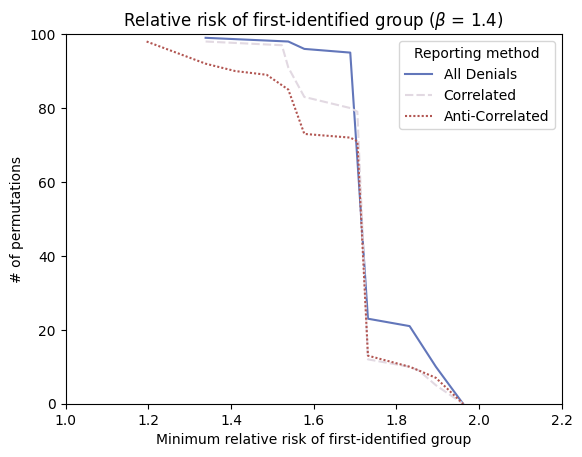

In [49]:
# g = sns.scatterplot(data=full.sample(frac=1), x='rr', y='order', palette='twilight_shifted', style='report', hue='report') #, ci=None, estimator=None)
g = sns.lineplot(data=full, x='rr', y='order', palette='twilight_shifted', style='report', hue='report', ci=None, estimator = 'min')
g.legend_.set_title('Reporting method')
new_labels = ['All Denials', 'Correlated', 'Anti-Correlated']
for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)
g.set(xlim = (1, 2.2), ylim=(0,100))
g.set(xlabel='Minimum relative risk of first-identified group', ylabel='# of permutations', title=rf'Relative risk of first-identified group ($\beta$ = {BETA}) ') #, {ALG[1]})')
plt.show(g)
